# TensorFlow Tutorial #12
# Adversarial Noise for MNIST

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

이전 튜토리얼 11 은 최신 신경망에 대해서 사람 눈으로는 동일하게 보이는 이미지라도 잘못 분류하게 만드는 적대적 예제라 불리는 것을 찾는 법을 보였다. 예를 들어, 적대적 노이즈가 추가된 parrot 의 이미지는 bookcase 로 잘못 분류 되었지만, 사람 눈에는 완벽하게 바뀌지 않은 것으로 보였다.

튜토리얼 11에서 적대적 노이즈는 각 개별 이미지에 대해 최적화 과정을 통해 찾았었다. 왜냐하면 이 노이즈는 일반화되지 않고 다른 이미지에는 효과가 없는 각 이미지에 특화된 것이었기 때문이다. 

이 튜토리얼은 거의 모든 입력 이미지를 원하는 타겟 클래스로 잘못 분류하게 만드는 적대적 노이즈를 찾을 것이다. MNIST 데이터셋이 사용된다. 이 적대적 노이즈는 사람 눈으로 명확히 볼 수 있지만 신경망이 거의 모든 이미지를 잘못 분류할 때 여전히 사람은 쉽게 식별한다.

이 튜토리얼은 적대적 노이즈에 면역인 신경망을 만들려고 시도할 것이다

튜토리얼 11은 적대적 최적화에 대해 넘파이가 사용되었다. 이 튜토리얼에서 우리는 텐서플로에서 직접적으로 최적화 과정을 구현하는 법을 볼 것이다. 이것은 특히 GPU를 사용할 때 더 빠르다. 왜냐하면 이것은 데이터를 복사할 필요가 없기 때문이다.

튜토리얼 11을 먼저 공부하기를 추천한다. 전반적으로 텐서플로에 익숙해야만 한다. 튜토리얼 1과 2를 보라

## Flowchart

아래 차트는 아래 구현된 콘볼루션 신경망에서 데이터가 어떻게 흐르는지 대략적으로 보여준다.

이 예제는 숫자 7의 입력 이미지를 보여준다. 적대적 노이즈가 이미지에 더해진다. 빨간 노이즈 픽셀은 양이고 이들 픽셀에서 이미지는 더 짙어진다. 반면 파랑 노이즈 픽셀은 음이고 이들 픽셀에서 더 밝아진다.

노이즈 낀 이미지는 예측 클래스 숫자를 결과로 하는 신경망에 보내진다. 이 경우 적대적 노이즈는 신경망이 7으로 보이는 숫자를 3로 믿게 만든다. 이 노이즈는 명확히 사람에게 보이지만 여전히 사람은 쉽게 7로 식별한다.

밑줄 쳐야하는 것은 단일 노이즈 패턴이 거의 모든 입력 이미지들을 원하는 타겟 클래스로 잘못 분류하게 만든다는 것이다.

신경망에서 두개의 분리된 최적화 과정이 있다. 첫째 우리는 학습 데이터셋 안에 이미지들을 분류하기 위해 신경망의 변수들을 최적화한다. 신경망의 일반적인 최적화 과정이다. 분류 정확도가 충분해지면, 모든 입력 이미지를 주어진 타겟 클래스로 잘못 분류하게 만드는 적대적 노이즈의 단일 패턴을 찾기를 시도하는 두번째 최적화 과정으로 바꾼다.

이 두개의 최적화 과정은 완벽히 분리되어 있다. 첫째 과정은 오직 신경망의 변수들만 바꾸지만 두번째 과정은 오직 적대적 노이즈만 바꾼다.

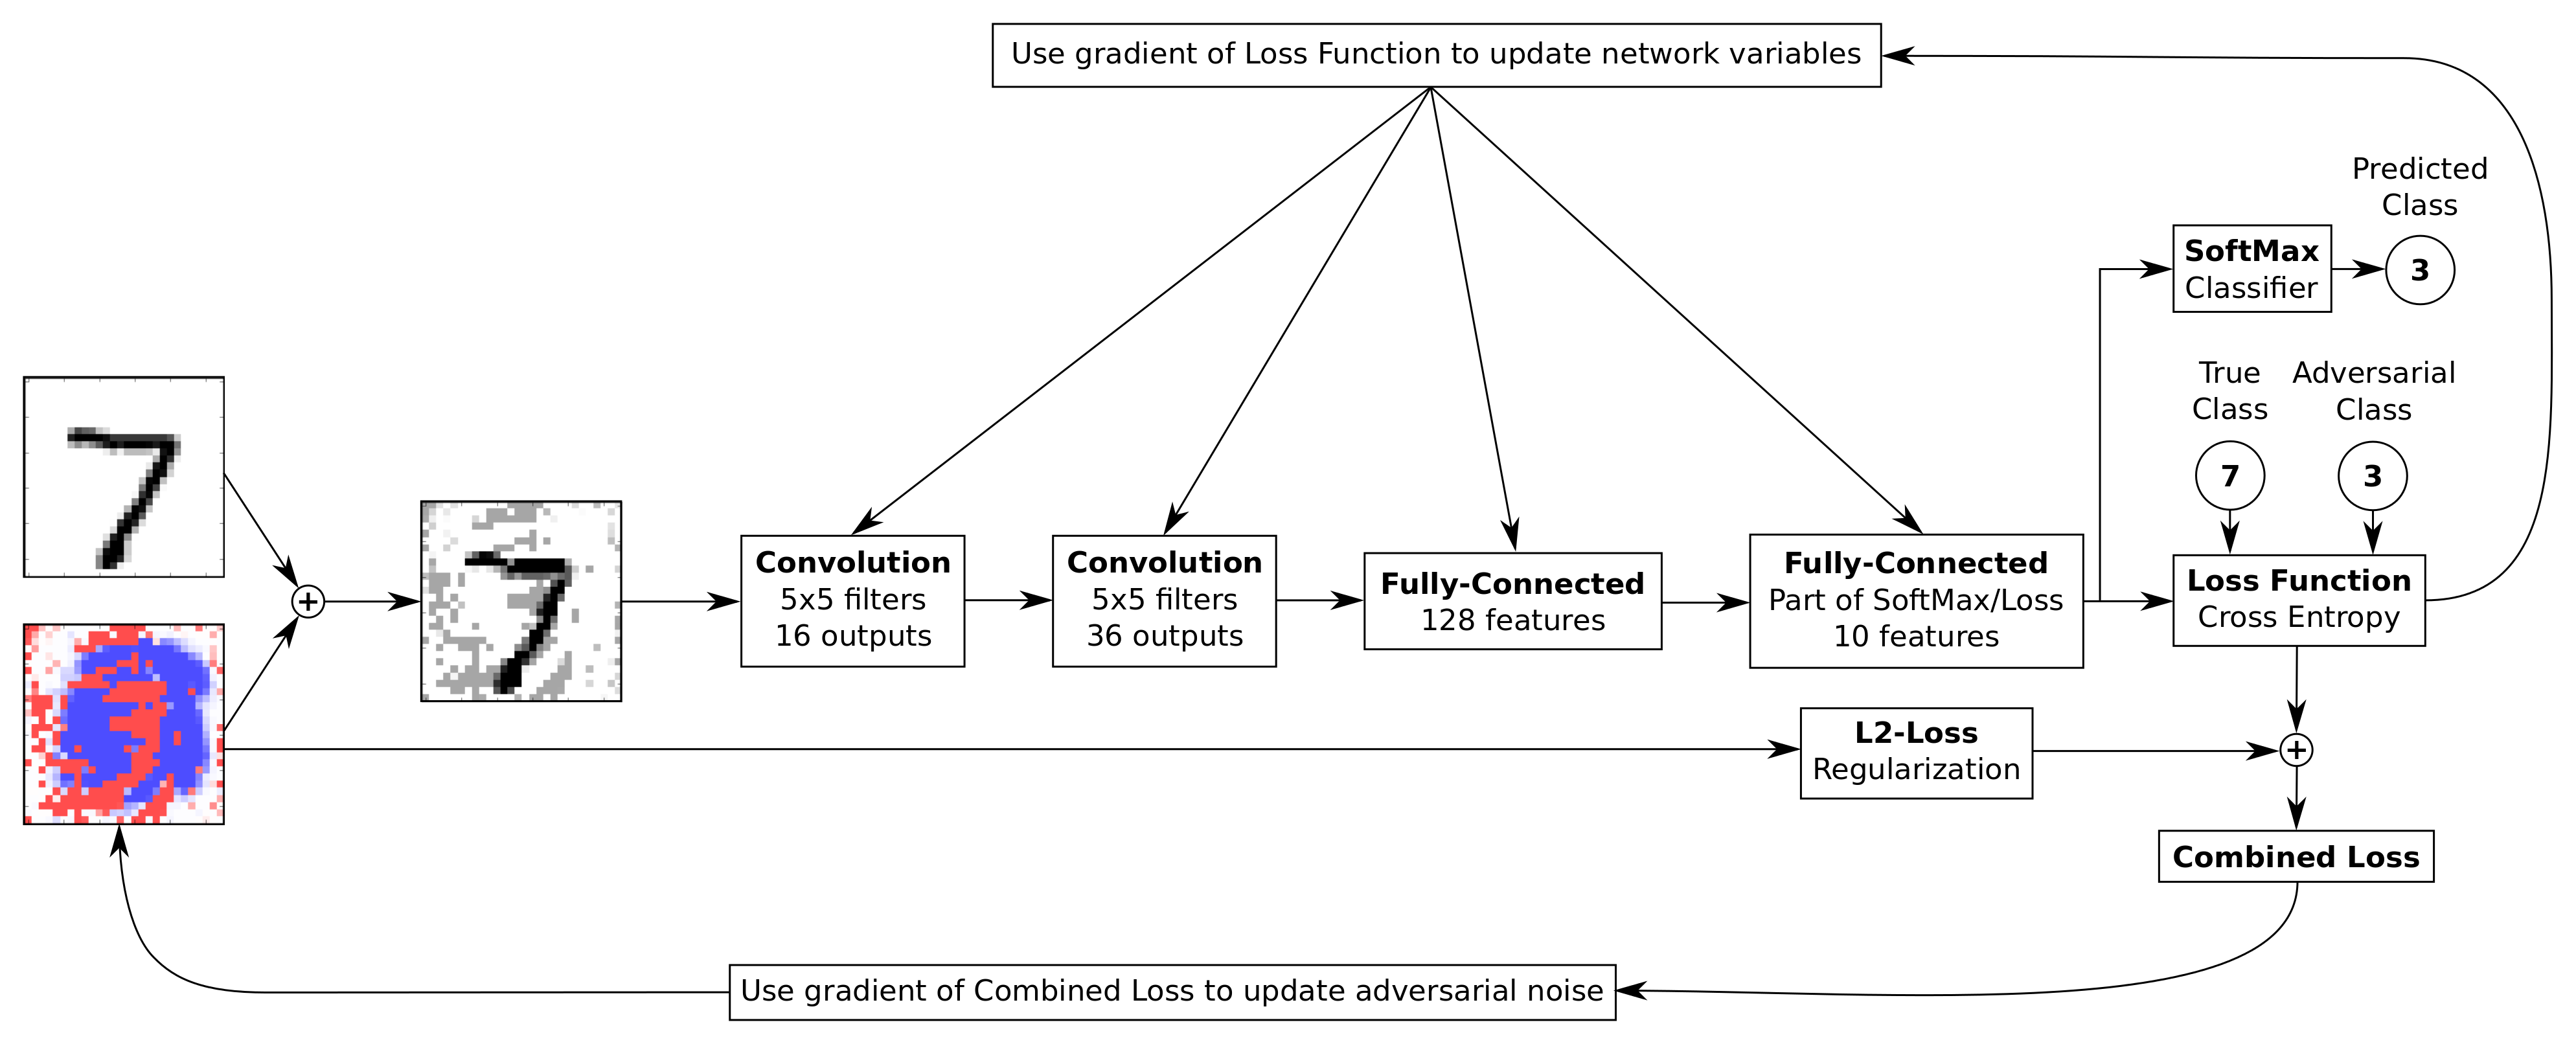

In [1]:
from IPython.display import Image
Image('images/12_adversarial_noise_flowchart.png')

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

# We also need PrettyTensor.
import prettytensor as pt

파이썬 3.5.2 (아나콘다)와 텐서플로 1.0.1 버젼으로 함

In [3]:
tf.__version__

'1.0.1'

PrettyTensor version:

In [4]:
pt.__version__

'0.7.4'

## Load Data

MNIST 데이터셋은 약 12 MB 정도고, 주어진 경로에 없다면 자동으로 받아짐

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


MNIST 데이터셋은 70,000 장의 이미지와 라벨로 구성되어 있다. 
이 데이터셋은 상호 배타적인 3개로 나뉘어 있다. 
이 튜토리얼에서는 학습과 테스트만 사용할 것이다.

In [6]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


클래스 라벨들은 One-Hot encode 되어있다. 이것은 해당 라벨만 1이고 나머지는 0인 10의 길이를 갖는 벡터로 되어 있음을 의미한다. 우리는 또한 테스트 셋에 대한 비교를 위해 정수도 필요하다.

In [7]:
data.test.cls = np.argmax(data.test.labels, axis=1)

### Data Dimensions

데이터 차원은 아래 보이는 소스코드 여러군데에서 사용된다. 

컴퓨터프로그래밍에서 일반적으로 사용할 모든 숫자를 입력하는 하드코딩 보다는 변수나 상수를 사용하는 것이 최선이다. 

이것은 그 숫자들은 하나의 위치에서만 바꾸는 것을 의미한다. 

이상적으로 이것들은 자료에서 얻어질 것이지만, 여기서는 숫자들로 입력한다.

In [8]:
# MNIST 이미지의 각 차원은 28 픽셀이다
img_size = 28

# 이미지들은 1차원 벡터로 저장되어 있다
img_size_flat = img_size * img_size

# 높이와 너비를 갖는 튜플은 reshape 배열에 사용된다.
img_shape = (img_size, img_size)

# 이미지에 대한 색 채널의 수 : 흑백 채널은 1채널이다.
num_channels = 1

# 클래스의 숫자, 10개 숫자 각각이 하나의 클래스
num_classes = 10

### Helper-function for plotting images

3x3 격자에 9개의 이미지를 출력하고, 각 이미지에 대해 예측 클래스와 실제값을 보여주는 함수. 만약 노이즈가 제공되면 모든 이미지에 더해진다

In [9]:
def plot_images(images, cls_true, cls_pred=None, noise=0.0):
    # 이미지의 길이와 cls_true의 값이 9가 맞는지 확인 아니면 에러
    assert len(images) == len(cls_true) == 9
    
    # subplots로 3x3 격자 figure를 만듦
    fig, axes = plt.subplots(3, 3)
    # 각 격자의 떨어진 정도를 조정함
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    # 각 격자의 순서대로 넣기 위해 enumerate를 사용
    for i, ax in enumerate(axes.flat):
        # 이미지를 각 순서대로 넣음
        image = images[i].reshape(img_shape)
        
        # 이미지에 적대적 노이즈를 더한다
        image += noise
        
        # 노이즈 낀 픽셀 값들이 0과 1사이를 보장
        image = np.clip(image, 0.0, 1.0)

        # 이미지 표시
        ax.imshow(image,
                  cmap='binary', interpolation='nearest')

        # 실제와 예측 클래스 보여준다
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # x 축에 클래스를 라벨로 보여줌
        ax.set_xlabel(xlabel)
        
        # 눈금 지움
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

### Plot a few images to see if data is correct

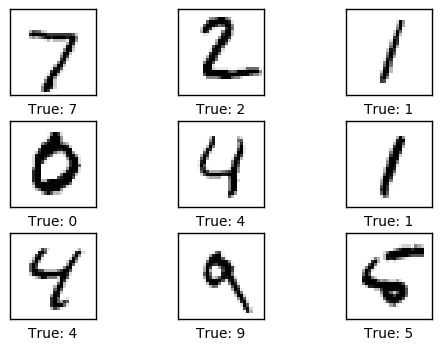

In [10]:
# 테스트셋에서 첫 9개 이미지 가져옴
images = data.test.images[0:9]

# 이들 이미지의 실제 클래스값 얻음
cls_true = data.test.cls[0:9]

# 위의 함수를 이용해 나타냄
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

신경망의 계산 그래프는 텐서플로와 PrettyTensor를 사용해 구성된다. 보통 우리는 그래프 속에 이미지를 보내기 위한 placeholder 변수를 만들고, 이 이미지에 적대적 노이즈를 더한다. 노이즈 낀 이미지는 콘볼루션 신경망에 입력으로 사용된다.

이 신경망에 두개의 분리된 최적화 과정이 있다. 신경망의 변수들에 대한 일반적인 최적화 과정과 적대적 노이즈에 대한 또다른 최적화 과정이다. 두 최적화 과정은 텐서플로에서 직접적으로 구현된다.

### Placeholder variables

Placeholder 변수는 그래프를 실행할 때마다 바뀔 수도 있는 입력을 그래프에 보낸다.

첫째, 입력 이미지에 대한 placeholder 변수를 정의한다. 텐서 그래프에 입력으로 변할 수 잇는 이미지를 보낸다. 이것이 다차원 벡터 혹은 행렬을 의미하는 텐서다. 데이터 타입은 float32 이고 모양은 [None, img_size_flat] 이다. None 은 정해지지 않았음을 의미한다. 각 이미지는 항상 img_size_flat의 길이를 갖는다.

In [11]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

콘볼루션 레이어들은 4차원 텐서를 입력 x 로 기대한다. 그래서 우리는 [num_images, img_size_flat] 대신에 [num_images, img_height, img_width, num_channels]의 모양을 갖도록 변형해야하낟. img_height == img_width == img_size 이고 num_images 는 첫번째 차원에 -1을 사용해 자동으로 계산하게 할 수 있다. 그래서 이미지로 변경하는 연산은 다음과 같다.

In [12]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

다음으로 입력 이미지에 해당하는 실제 라벨의 placeholder를 만든다. 이 placeholder 변수의 모양은 [None, num_classes] 이다. None은 미정이고, num_classes 는 여기서는 10이다.

In [13]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

클래스 숫자에 대한 placeholder 변수를 만들 수도 있지만, 대신 argmax를 사용해 이것을 계산한다. 이것은 텐서플로 연산이다 그러므로 이 시점에서 아무것도 계산되지 않는다.

In [14]:
y_true_cls = tf.argmax(y_true, dimension=1)

### Adversarial Noise

입력 이미지에 픽셀들은 0.0과 1.0의 float 값들이다. 적대적 노이즈는 입력 이미지 픽셀에 더해지거나 빼지는 숫자다

적대적 노이즈의 한계는 0.35로 설정하므로 노이즈는 &plusmn;0.35. 사이일 것이다.

In [15]:
noise_limit = 0.35

적대적 노이즈를 위한 최적화기는 두개의 손실을 최소화하는 것을 시도한다: (1) 신경망에 대한 일반적인 손실 그러므로 적대적 타겟 클래스에 대해 최고의 분류 정확도를 주는 노이즈를 찾을 것이고, (2) 노이즈를 가능한 한 작게 유지하도록 하는 L2-손실이라 불리는 것이다.

아래 가중치는 일반적인 손실과 비교하여 L2-loss를 얼만큼 중요하게 볼 것인지를 결정한다. L2-weight는 보통 0에 가까운게 최선이다.

In [16]:
noise_l2_weight = 0.02

노이즈를 위한 새 변수를 만들 때, 어디에 속한지를 나타내는 variable-collection을 텐서플로에 알려야만, 나중에 변수들을 업데이트할 두 최적화기에 알릴 수 있다.

먼저 새로운 variable-collection에 대한 이름을 정의한다. 이것은 단순히 문자열이다.

In [17]:
ADVERSARY_VARIABLES = 'adversary_variables'

새로운 노이즈 변수가 어디에 속하는지를 나타내는 이 콜렉션의 리스트를 만든다. 만약 이 노이즈 변수가 `tf.GraphKeys.VARIABLES` 에 더해진다면,  텐서플로 그래프에서 다른 변수들과 함께 초기화될 것이지만 최적화 되지는 않는다. 이것은 약간 혼란스럽다.

In [18]:
collections = [tf.GraphKeys.GLOBAL_VARIABLES, ADVERSARY_VARIABLES]

이제 우리는 적대적 노이즈에 대한 새로운 변수를 만들 수 있다. 이것은 0으로 초기화 될 것이다. 학습되지 않을 것으므로 신겸앙의 다른 변수들과 함게 최적화 되지 않을 것이다. 두개의 분리된 최적화 과정을 만들 수 있다.

In [19]:
x_noise = tf.Variable(tf.zeros([img_size, img_size, num_channels]),
                      name='x_noise', trainable=False,
                      collections=collections)

적대적 노이즈는 위에서 설정한 주어진 &plusmn; noise-limit 로 잘린다. 이것은 실제로 이 시점에 실행되지 않고, 최적화 과정 후에 실행된다.

In [20]:
x_noise_clip = tf.assign(x_noise, tf.clip_by_value(x_noise,
                                                   -noise_limit,
                                                   noise_limit))

노이즈 낀 이미지는 입력 이미지와 적대적 노이즈의 합이다.

In [21]:
x_noisy_image = x_image + x_noise

입력 이미지에 노이즈를 더할 때, 유효한 이미지의 경계를 넘을 수 있으므로 노이즈 낀 이미지의 픽셀 값들이 0 과 1 사이에 있는 것을 보장한다

In [22]:
x_noisy_image = tf.clip_by_value(x_noisy_image, 0.0, 1.0)

### Convolutional Neural Network

우리는 콘볼루션 신경망을 구성하기 위해 PrettyTensor를 사용할 것이다. 먼저 우리는 노이즈 낀 이미지를 신경망을 구성하는 함수를 제공하는 PrettyTensor 객체로 wrap할 필요가 있다.

In [23]:
x_pretty = pt.wrap(x_noisy_image)

PrettyTensor 객체 안에 입력 이미지를 wrap 했다. 몇 줄의 소스코드 에서 우리는 콘볼루션과 완전 연결 레이어를 더할 수 있다.

In [24]:
with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        conv2d(kernel=5, depth=16, name='layer_conv1').\
        max_pool(kernel=2, stride=2).\
        conv2d(kernel=5, depth=36, name='layer_conv2').\
        max_pool(kernel=2, stride=2).\
        flatten().\
        fully_connected(size=128, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

`pt.default_scope(activation_fn=tf.nn.relu)` 는 `with` 블록 내에 구성된 각 레이어들에 인자로 `activation_fn=tf.nn.relu` 만든다. 그래서 이들 레이어에는 ReLU가 사용된다. `defaults_scope`는 모든 레이어에 대한 인자를 변경하기 쉽게 만든다.

### Optimizer for Normal Training

일반적인 최적화 과정동안 학습될 신경망의 변수 리스트들이다.
`'x_noise:0'` 은 리스트에 없으므로 적대적 노이즈는 일반적인 과정에서 최적화되지 않는다.

In [25]:
[var.name for var in tf.trainable_variables()]

['layer_conv1/weights:0',
 'layer_conv1/bias:0',
 'layer_conv2/weights:0',
 'layer_conv2/bias:0',
 'layer_fc1/weights:0',
 'layer_fc1/bias:0',
 'fully_connected/weights:0',
 'fully_connected/bias:0']

시견망에서 이들 변수들의 최적화는 위에 구성된 PrettyTensor로부터 반횐되는 손실을 사용해 Adam 최적화기로 수행된다.

이 최적화는 이시점에서 수행되지 않는다. 사실 어떤 것도 전혀 계산되지 않는다. 우리는 단지 나중에 실행될 텐서플로 그래프에 최적화기 객체를 더할 뿐이다.

In [26]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

### Optimizer for Adversarial Noise

적대적 노이즈에 대한 두번째 과정에서 최적화되야만 하는 변수들을 얻는다

In [27]:
adversary_variables = tf.get_collection(ADVERSARY_VARIABLES)

변수 이름의 리스트를 보자. 위에서 만든 적대적 노이즈 변수 하나다

In [28]:
[var.name for var in adversary_variables]

['x_noise:0']

노이즈 변수에 대한 L2-loss 라 불리는 것과 일반적인 최적화에 대한 손실 함수를 더한다. 최고의 분류 정확도와 함께 적대적 노이즈에 대해선 최소 값을 결과로 가져야만 한다.

L2-loss 는 0에 가깝게 초기화되 weight 에 의해 스케일링 된다.

In [29]:
l2_loss_noise = noise_l2_weight * tf.nn.l2_loss(x_noise)

적대적 노이즈에 대한 L2-loss와 함께 일반적 손실 함수를 결합한다.

In [30]:
loss_adversary = loss + l2_loss_noise

우리는 이제 적대적 노이즈에 대한 최적화기를 만들 수 있다. 왜냐하면 이 최적화기는 신경망의 모든 변수를 업데이트하지 않기 때문이다. 우리는 업데이트 하기를 원하는 변수의 리스트를 줘야만 한다. 학습률은 일반적인 최적화기보다 훨씬 더 크다

In [31]:
optimizer_adversary = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(loss_adversary, var_list=adversary_variables)

우리는 이제 신경망에 대해 두개의 최적화기를 만들었다. 하나는 신경망의 변수들에 대한 것이고 또다른 하나는 적대적 노이즈를 갖는 하나의 변수에 대한 것이다.

### Performance Measures

최적화 동안 사용자에게 진행을 표시하는 것을 쉽게 만들어줄 텐서플로 그래프에 몇가지 연산이 더 필요하다

먼저 10개 요소를 갖는 벡터인 신경망의 출력 `y_pred` 로부터 예측 클래스 숫자를 계산한다. 이 클래스 숫자는 가장 큰 요소의 인덱스이다.

In [32]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

각 이미지의 실제 클래스와 예측 클래스가 같은지 다른지를 나타내는 진리값 벡터를 만든다.

In [33]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

분류 정확도는 진리값 벡터를 float로 바꿔서 계산한다. 그러면 False 는 0 True는 1이 되므로 이들 숫자를 평균한다

In [34]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

### Create TensorFlow session

텐서플로 그래프가 만들어지면, 우리는 그래프를 실행하기 위해 사용되는 텐서플로 세션을 만들어야만 한다.

In [35]:
# gpu 에러를 방지
config = tf.ConfigProto(
        device_count={'GPU': 0}  # uncomment this line to force CPU
    )
session = tf.Session(config=config)

### Initialize variables

`weights` 와 `biases`에 대한 변수들은 최적화를 시작하기 전에 초기화되어야만 한다.

In [36]:
session.run(tf.global_variables_initializer())

적대적 노이즈를 0으로 초기화하는 도움함수

In [37]:
def init_noise():
    session.run(tf.variables_initializer([x_noise]))

적대적 노이즈를 초기화하기 위해 함수를 호출한다

In [38]:
init_noise()

### Helper-function to perform optimization iterations

학습 데이터셋에 5만5천개 이미지가 있다. 모든 이미지를 사용해 그라디언트를 계산하는데에는 너무 오래걸린다. 그래서 매 반복마다 이미지의 표본을 사용하는 확률적 기울기 강하(Stochastic Gradient Descent)를 사용한다.

만약 컴퓨터가 RAM 때문에 너무 느리거나 멈추면, 더 작은 수를 시도해라.

In [39]:
train_batch_size = 64

신경망의 변수들을 점진적으로 향상시키기 위해 최적화 반복을 수행하는 함수. 각 반복에서, 데이터의 새로운 batch 가 선택되고 텐서플로는 이들 학습 표본을 사용해 최적화기를 실행한다. 이 과정은 매 100 번 반복마다 출력된다.

이 함수는 적대적 타겟 클래스에 대한 인지를 받는다는 것을 제외하고는 이전 튜토리얼에서와 유사하다. 이 타겟 클래스는 정수로 설정되고, 이것은 학습 데이터에 실제 클래스 숫자 대신 사용될 것이다. 적대적 최적화기가 일반 최적화기 대신 사용되고 적대적 최적화기의 매 단계 후에 이 노이즈는 허용 범위로 잘린다. 이것은 적대적 노이즈를 최적화하고 신경망의 다른 변수들은 무시한다

In [40]:
# 반복횟수를 인자로 받는다
def optimize(num_iterations, adversary_target_cls=None):
    # 아래에 사용된 시간을 나타내는 start_time
    start_time = time.time()

    for i in range(num_iterations):

        # 학습 데이터의 표본을 얻는다.
        # x_batch는 이미지의 표본을 가지고 있고,
        # y_true_batch는 이들 이미지에 대한 실제 라벨을 갖고 있다.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # 만약 적대적 노이즈에 대한 탐색중이면 대신 적대적 타겟 클래스가 사용된다
        if adversary_target_cls is not None:
            # 클래스 라벨은 One-Hot 인코딩 되어있다.
            
            # 모든 클래스 라벨은 0으로 초기화한다
            y_true_batch = np.zeros_like(y_true_batch)

            # 적대적 타겟 클래스의 요소만 1로 설정한다
            y_true_batch[:, adversary_target_cls] = 1.0
            
        # 텐서플로 그래프에서 placeholder 변수의 이름을 갖는 사전속에 표본을 넣는다.
        # y_true_cls placeholder 에 대해서는 설정하지 않는다. 왜냐하면 이것은 학습동안 사용되지 않기 때문이다.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # 신경망의 일반적인 최적화를 수행한다면
        if adversary_target_cls is None:
            # 학습 데이터 배치를 사용해 최적화기를 실행한다
            # 텐서플로는 placeholder 변수에 feed_dict_train을 할당하고 최적화기를 실행한다
            session.run(optimizer, feed_dict=feed_dict_train)
        else:
            # 적대적 최적화기를 실행한다
            # 우리는 '가짜' 클래스를 실제 클래스 대신 사용한다
            session.run(optimizer_adversary, feed_dict=feed_dict_train)
            
            # 적대적 노이즈를 자른다. 또다른 텐서플로 연산을 실행한다
            # 최적화기와 같은 session.run()에서 실행될 수 없다
            # 왜냐하면 이것은 병렬적으로 실행되기 때문에 실행 순서는 보장되지 않는다.
            # 최적화기 다음에 실행해야한다
            session.run(x_noise_clip)

        # 매 100번 반복마다 출력
        if (i % 100 == 0) or (i == num_iterations - 1):
            # 학습 데이터셋에 대한 정확도를 계산한다
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # 출력할 메시지
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            print(msg.format(i, acc))

    # 끝난 시간
    end_time = time.time()

    # 시작 시간과 끝난 시간의 차이
    time_dif = end_time - start_time

    # 사용 시간 출력
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper-functions for getting and plotting the noise

This function gets the adversarial noise from inside the TensorFlow graph.
텐서플로 그래프 안에서부터 적대적 노이즈를 얻는 함수

In [41]:
def get_noise():
    #그래프에서 x_noise 변수의 내용을 가져오기 위해 텐서플로 세션을 실행한다
    noise = session.run(x_noise)

    return np.squeeze(noise)

적대적 노이즈를 표시하고 몇몇 통계량을 출력하는 함수

In [42]:
def plot_noise():
    # 텐서플로 그래프 내에 적대적 노이즈를 가져온다
    noise = get_noise()
    
    # 통계량을 출력
    print("Noise:")
    print("- Min:", noise.min())
    print("- Max:", noise.max())
    print("- Std:", noise.std())

    # 노이즈를 표시
    plt.imshow(noise, interpolation='nearest', cmap='seismic',
               vmin=-1.0, vmax=1.0)

### Helper-function to plot example errors

잘못 분류된 테스트셋의 이미지를 표시하는 함수

In [43]:
def plot_example_errors(cls_pred, correct):
    # 이 함수는 print_test_accuracy() 로부터 불러와진다.
    # cls_pred는 테스트 셋에 모든 이미지에 대한 예측된 클래스의 배열
    
    # correct 는 테스트 셋에 모든 이미지에 대한 실제와 예측의 진리값
    
    # 잘못 분류된 인덱스를 얻는다
    incorrect = (correct == False)
    
    # 올바르게 분류되지 않은 이미지를 얻는다
    images = data.test.images[incorrect]
    
    # 이들 이미지의 예측 클래스를 얻는다
    cls_pred = cls_pred[incorrect]

    # 이들 이미지의 실제 클래스를 얻는다.
    cls_true = data.test.cls[incorrect]

    # 적대적 노이즈를 얻는다
    noise = get_noise()
    
    # 9개의 이미지를 나타낸다.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9],
                noise=noise)

### Helper-function to plot confusion matrix

In [44]:
def plot_confusion_matrix(cls_pred):
    # 이 함수는 아래의 print_test_accuracy() 로부터 호출된다.
    
    # cls_pred는 테스트 셋에 모든 이미지에 대한 예측된 클래스의 배열
    
    # 테스트셋에 대한 실제 분류를 얻는다
    cls_true = data.test.cls
    
    # sklearn을 이용해 혼동 행렬을 얻는다.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # 혼동행렬을 텍스트로써 출력한다.
    print(cm)

### Helper-function for showing the performance

테스트 셋에 대한 분류 정확도를 출력하는 함수

테스트 셋에 모든 이미지에 대한 분류를 계산한다. 결과는 이 함수로부터 직접적으로 위의 함수에 호출되어 재사용된다. 그래서 분류는 각 함수마다 재 계산되지 않는다.

이 함수는 컴퓨터 메모리를 많이 사용할 수 있으므로 테스트 셋을 작은 배치로 만드는 이유이다. 컴퓨터에 RAM 이 거의 없고 충돌나면, 더 작은 수의 배치를 사용할 수 있다.

In [45]:
# 테스트셋을 작은 사이즈의 배치로 나눈다.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # 테스트셋의 이미지의 수
    num_test = len(data.test.images)

    # 배치에서 계산되기 위한 예측 클래스의 배열을 할당하고 이 배열 속에 채운다.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # 배치에 대해 예측 클래스를 계산한다.
    # 모든 배치에 대해 반복할 것

    # 배치를 위한 순번 초기화
    i = 0

    while i < num_test:
        # j 는 배치의 끝 번호
        j = min(i + test_batch_size, num_test)

        # i부터 j까지 이미지 꺼내오기
        images = data.test.images[i:j, :]

        # i부터 j까지 라벨 꺼내오기
        labels = data.test.labels[i:j, :]

        # 이미지와 라벨을 feed_dict 으로 만든다
        feed_dict = {x: images,
                     y_true: labels}

        # 텐서플로를 사용해 예상 클래스를 만든다
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # 다음 배치를 위해 i를 j로 바꾼다
        i = j

    # 테스트 셋의 실제 클래스를 모은다.
    cls_true = data.test.cls

    # 예상 클래스와 실제 클래스르 비교한다.
    correct = (cls_true == cls_pred)

    # 맞은 수를 센다
    correct_sum = correct.sum()

    # 맞은 수를 전체 수로 나눠서 정확도를 계산한다.
    acc = float(correct_sum) / num_test

    # 정확도 표시
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # 원한다면 틀린 그림을 표시할 수 있다
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # 원한다면 혼동 행렬을 표시할 수 있다
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Normal optimization of neural network

먼저 우리는 일반 최적화기로 1000번 반복을 수행한다. 이것은 학습 데이터셋에 잘 작동하는 신경망을 만들기위한 변수들을 찾는다

최적화 노이즈는 아직 영향이 없다 왜냐하면 이것은 0으로 초기화 되어 있고 이 최적화 동안 업데이트되지 않기 때문이다.

In [46]:
optimize(num_iterations=1000)

Optimization Iteration:      0, Training Accuracy:  18.8%
Optimization Iteration:    100, Training Accuracy:  85.9%
Optimization Iteration:    200, Training Accuracy:  84.4%
Optimization Iteration:    300, Training Accuracy:  85.9%
Optimization Iteration:    400, Training Accuracy:  85.9%
Optimization Iteration:    500, Training Accuracy:  92.2%
Optimization Iteration:    600, Training Accuracy:  95.3%
Optimization Iteration:    700, Training Accuracy:  95.3%
Optimization Iteration:    800, Training Accuracy:  92.2%
Optimization Iteration:    900, Training Accuracy: 100.0%
Optimization Iteration:    999, Training Accuracy:  95.3%
Time usage: 0:01:03


분류 정확도는 테스트셋에 대해 약 96-97% 정도이다. (이것은 파이썬 노트북을 실행할 때마다 매번 다르다)

Accuracy on Test-Set: 96.4% (9635 / 10000)
Example errors:


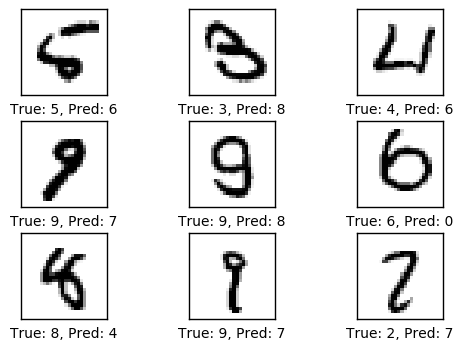

In [47]:
print_test_accuracy(show_example_errors=True)

## Find the adversarial noise

적대적 노이즈를 최적화기 전에, 먼저 0으로 초기화한다. 이미 위에서 했지만 다른 타겟 클래스와 함께 코드를 재 실행하기를 원할 때 여기서부터 반복된다.

In [48]:
init_noise()

적대적 노이즈의 최적화를 수행한다. 일반 최적화기 대신 신경망의 다른 모든 변수는 무시하고 적대적 노이즈에 대한 변수 하나만을 최적화하는 적대적 최적화기를 사용한다

In [49]:
optimize(num_iterations=1000, adversary_target_cls=3)

Optimization Iteration:      0, Training Accuracy:   6.2%
Optimization Iteration:    100, Training Accuracy:  98.4%
Optimization Iteration:    200, Training Accuracy:  95.3%
Optimization Iteration:    300, Training Accuracy:  95.3%
Optimization Iteration:    400, Training Accuracy:  96.9%
Optimization Iteration:    500, Training Accuracy: 100.0%
Optimization Iteration:    600, Training Accuracy:  96.9%
Optimization Iteration:    700, Training Accuracy:  96.9%
Optimization Iteration:    800, Training Accuracy:  98.4%
Optimization Iteration:    900, Training Accuracy:  98.4%
Optimization Iteration:    999, Training Accuracy:  98.4%
Time usage: 0:01:02


적대적 노이즈는 최적화되었고 표시할 수 있다. 빨간 픽셀들은 양의 노이즈 값들이고 파란 픽셀들은 음의 노이즈 값들이다. 이 노이즈 패턴은 매 입력 이미지에 더해진다. 이 양의 (빨강) 노이즈 값들은 픽셀들은 더 어둡게 만들고 음의 (파랑) 노이즈 값들은 픽셀들을 더 밝게 만든다. 예제는 아래에 있다.

Noise:
- Min: -0.35
- Max: 0.35
- Std: 0.194379


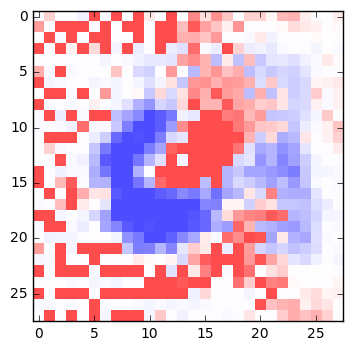

In [50]:
plot_noise()

테스트셋 안에 모든 이미지에 이 노이즈가 더해진다면, 그 결과는 일반적으로 선택된 타겟 클래스에 대해 10-15% 분류 정확도이다.

그래서 우리는 우리가 바라는 타겟 클래스로 테스트셋 안에 모든 이미지를 잘못 분류하는 신경망을 만드는 적대적 노이즈를 찾았다.

적대적 노이즈를 갖는 잘못 분류된 이미지의 예제를 볼 수 있다. 이 노이즈는 명확히 보이지만 숫자는 여전히 사람 눈에는 쉽게 식별된다.

Accuracy on Test-Set: 12.8% (1282 / 10000)
Example errors:


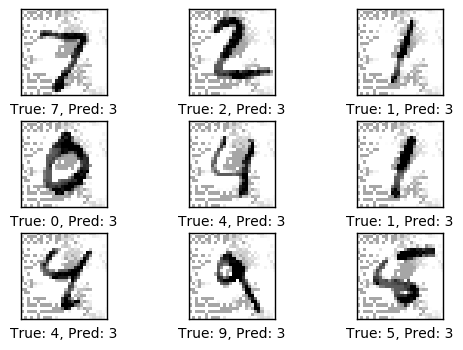

Confusion Matrix:
[[  86    0    0  894    0    0    0    0    0    0]
 [   0    0    0 1135    0    0    0    0    0    0]
 [   0    0   77  954    0    0    0    0    1    0]
 [   0    0    0 1010    0    0    0    0    0    0]
 [   0    0    0  958   20    0    0    1    3    0]
 [   0    0    0  888    0    4    0    0    0    0]
 [   0    0    2  925    0    1   28    0    2    0]
 [   0    0    0 1005    0    0    0   23    0    0]
 [   0    0    0  941    0    0    0    0   33    0]
 [   0    0    1 1007    0    0    0    0    0    1]]


In [51]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## Adversarial noise for all target-classes

모든 타겟 클래스에 대해 적대적 노이즈를 찾기 위한 도움 함수. 이 함수는 0부터 9까지 모든 클래스 숫자에 대해 위의 최적화를 반복 실행한다. 그 결과는 배열에 저장된다.

In [52]:
def find_all_noise(num_iterations=1000):
    # 모든 타겟 클래스들의 적대적 노이즈
    all_noise = []

    # 각 타겟 클래스에 대해 반복
    for i in range(num_classes):
        print("Finding adversarial noise for target-class:", i)

        # 적대적 노이즈를 0으로 초기화
        init_noise()

        # 적대적 노이즈 최적화
        optimize(num_iterations=num_iterations,
                 adversary_target_cls=i)

        # 텐서플로 그래프에서 적대적 노이즈를 얻는다
        noise = get_noise()

        # 배열에 노이즈를 더한다
        all_noise.append(noise)

        print()
    
    return all_noise

In [53]:
all_noise = find_all_noise(num_iterations=300)

Finding adversarial noise for target-class: 0
Optimization Iteration:      0, Training Accuracy:   4.7%
Optimization Iteration:    100, Training Accuracy:  89.1%
Optimization Iteration:    200, Training Accuracy:  92.2%
Optimization Iteration:    299, Training Accuracy:  82.8%
Time usage: 0:00:19

Finding adversarial noise for target-class: 1
Optimization Iteration:      0, Training Accuracy:  12.5%
Optimization Iteration:    100, Training Accuracy:  43.8%
Optimization Iteration:    200, Training Accuracy:  45.3%
Optimization Iteration:    299, Training Accuracy:  35.9%
Time usage: 0:00:20

Finding adversarial noise for target-class: 2
Optimization Iteration:      0, Training Accuracy:  12.5%
Optimization Iteration:    100, Training Accuracy:  92.2%
Optimization Iteration:    200, Training Accuracy: 100.0%
Optimization Iteration:    299, Training Accuracy:  95.3%
Time usage: 0:00:19

Finding adversarial noise for target-class: 3
Optimization Iteration:      0, Training Accuracy:   7.8%

### Plot the adversarial noise for all target-classes

0부터 9까지 모든 타겟 클래스에 대한 적대적 노이즈를 갖는 격자를 표시하기 위한 함수

In [54]:
def plot_all_noise(all_noise):    
    # 10개의 subplot을 갖는 figure 를 만든다
    fig, axes = plt.subplots(2, 5)
    # 간격 조정
    fig.subplots_adjust(hspace=0.2, wspace=0.1)

    # 각 서브 플랏에 대해 반복
    for i, ax in enumerate(axes.flat):
        # i 번째 타겟 클래스에 대한 적대적 노이즈를 얻는다
        noise = all_noise[i]
        
        # 노이즈 표시
        ax.imshow(noise,
                  cmap='seismic', interpolation='nearest',
                  vmin=-1.0, vmax=1.0)

        # x축 라벨에 클래스 설정
        ax.set_xlabel(i)

        # 눈금 제거
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

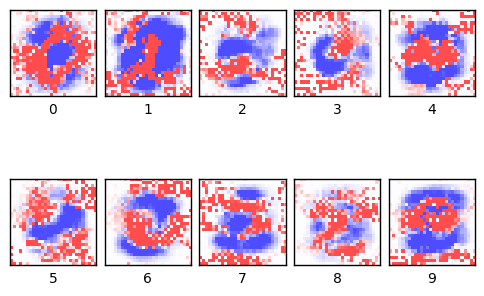

In [55]:
plot_all_noise(all_noise)

빨간 픽셀들은 양의 노이즈 값들이고 파란 픽셀들은 음의 노이즈 값들이다.

이들 노이즈 이미지의 몇몇은 그 숫자의 흔적을 볼 수 있다. 예를 들어, 타겟 클래스 0에 대한 노이즈는 빨간 원 주위에 파란색이 둘러싸고 있는 것이 보인다. 이것은 원 모양이 입력 이미지에 더해지는 것을 의미한다. 다른 픽셀들은 약해진다. 이것은 MNIST 데이터셋에 대부분의 입력 이미지들이 0으로 잘못 분류되기에 충분하다. 또다른 예제는 빨간 픽셀들을 갖는 숫자 3의 흔적이 보이는 3에 대한 노이즈이다. 하지만 다른 클래스의 노이즈는 덜 분명하다.

## Immunity to adversarial noise

우리는 이제 적대적 노이즈에 면역이 있는 신경망을 만들기를 시도한다. 적대적 노이즈를 무시하기 위해 신경망을 재 학습함으로써 된다. 이 과정은 여러번 반복될 수 있다.

### Helper-function to make a neural network immune to noise

적대적 노이즈에 면역인 신경망을 만들기 위한 함수. 먼저 적대적 노이즈를 찾기 위해 최적화를 실행한다. 그런다음 이 노이즈에 면역인 신경망을 만들기 위해 일반 최적화기를 실행한다.

In [56]:
def make_immune(target_cls, num_iterations_adversary=500,
                num_iterations_immune=200):

    print("Target-class:", target_cls)
    print("Finding adversarial noise ...")

    # 적대적 노이즈 찾기
    optimize(num_iterations=num_iterations_adversary,
             adversary_target_cls=target_cls)

    print()
    
    # 분류 정확도 출력
    print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False)

    print()

    print("Making the neural network immune to the noise ...")

    # 이 노이즈에 면역인 신경망을 만들기 위해 시도
    # 적대적 노이즈는 0으로 초기화되지 않으므로, x_noise 변수는 여전히 노이즈를 갖고 있다
    # 그래서 우리는 이 노이즈를 무시하도록 신경망을 학습한다.
    optimize(num_iterations=num_iterations_immune)

    print()
    
    # 분류 정확도 출력
    print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False)

### Make immune to noise for target-class 3

먼저 타겟 클래스 3에 대한 적대적 노이즈에 면역인 신경망을 만들기를 시도한다

먼저 신경망이 테스트셋 안에 모든 이미지를 잘못 분류하게 하는 적대적 노이즈를 찾는다. 그런다음 이 노이즈를 무시하도록 신경망의 변수들을 미세조정하는 일반 최적화를 실행한다. 노이즈 이미지에 대해 분류 정확도 95-97%를 다시 얻는다.

In [57]:
make_immune(target_cls=3)

Target-class: 3
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   3.1%
Optimization Iteration:    100, Training Accuracy:  95.3%
Optimization Iteration:    200, Training Accuracy:  95.3%
Optimization Iteration:    300, Training Accuracy:  96.9%
Optimization Iteration:    400, Training Accuracy: 100.0%
Optimization Iteration:    499, Training Accuracy:  95.3%
Time usage: 0:00:31

Accuracy on Test-Set: 13.4% (1337 / 10000)

Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  21.9%
Optimization Iteration:    100, Training Accuracy:  96.9%
Optimization Iteration:    199, Training Accuracy:  95.3%
Time usage: 0:00:13

Accuracy on Test-Set: 95.1% (9508 / 10000)


다시 실행한다. 이것은 이제 타겟 클래스 3에 대한 적대적 노이즈를 찾기 더 어려워졌다. 이 신경망은 적대적 노이즈에 약간 면역인 것처럼 보인다.

In [58]:
make_immune(target_cls=3)

Target-class: 3
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   6.2%
Optimization Iteration:    100, Training Accuracy:  28.1%
Optimization Iteration:    200, Training Accuracy:  10.9%
Optimization Iteration:    300, Training Accuracy:  20.3%
Optimization Iteration:    400, Training Accuracy:  25.0%
Optimization Iteration:    499, Training Accuracy:  17.2%
Time usage: 0:00:32

Accuracy on Test-Set: 79.2% (7925 / 10000)

Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  93.8%
Optimization Iteration:    100, Training Accuracy:  93.8%
Optimization Iteration:    199, Training Accuracy:  96.9%
Time usage: 0:00:13

Accuracy on Test-Set: 94.9% (9492 / 10000)


### Make immune to noise for all target-classes

모든 타겟 클래스에 대한 적대적 노이즈에 면역인 신경망을 만든다. 불행하게도 이것은 잘 작동하지 않는 것처럼 보인다.

In [59]:
for i in range(10):
    make_immune(target_cls=i)
    
    # Print newline.
    print()

Target-class: 0
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   9.4%
Optimization Iteration:    100, Training Accuracy:  67.2%
Optimization Iteration:    200, Training Accuracy:  75.0%
Optimization Iteration:    300, Training Accuracy:  79.7%
Optimization Iteration:    400, Training Accuracy:  79.7%
Optimization Iteration:    499, Training Accuracy:  78.1%
Time usage: 0:00:33

Accuracy on Test-Set: 28.3% (2826 / 10000)

Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  43.8%
Optimization Iteration:    100, Training Accuracy:  98.4%
Optimization Iteration:    199, Training Accuracy:  92.2%
Time usage: 0:00:13

Accuracy on Test-Set: 95.2% (9519 / 10000)

Target-class: 1
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   9.4%
Optimization Iteration:    100, Training Accuracy:  51.6%
Optimization Iteration:    200, Training Accuracy:  56.2%
Optimization Iteration:    300, 

### Make immune to all target-classes (double runs)

모든 타겟 클래스에 대한 적대적 노이즈에 면역인 신경망을 만들기 위해 두번 실행한다. 불행하게도 이것은 잘 작동하지 않는 것처럼 보인다.

신경망은 하나의 적대적 타겟 클래스에 면역인 신경망을 만드는 것은 다른 타겟 클래스에 대한 면역을 취소하는 것을 보인다.

In [60]:
for i in range(10):
    make_immune(target_cls=i)
    
    # Print newline.
    print()
    
    make_immune(target_cls=i)

    # Print newline.
    print()

Target-class: 0
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:   7.8%
Optimization Iteration:    100, Training Accuracy:  57.8%
Optimization Iteration:    200, Training Accuracy:  79.7%
Optimization Iteration:    300, Training Accuracy:  84.4%
Optimization Iteration:    400, Training Accuracy:  84.4%
Optimization Iteration:    499, Training Accuracy:  84.4%
Time usage: 0:00:34

Accuracy on Test-Set: 24.8% (2475 / 10000)

Making the neural network immune to the noise ...
Optimization Iteration:      0, Training Accuracy:  25.0%
Optimization Iteration:    100, Training Accuracy:  92.2%
Optimization Iteration:    199, Training Accuracy:  95.3%
Time usage: 0:00:13

Accuracy on Test-Set: 96.2% (9615 / 10000)

Target-class: 0
Finding adversarial noise ...
Optimization Iteration:      0, Training Accuracy:  15.6%
Optimization Iteration:    100, Training Accuracy:   3.1%
Optimization Iteration:    200, Training Accuracy:   9.4%
Optimization Iteration:    300, 

### Plot the adversarial noise

우리는 이제 신경망과 적대적 노이즈 모두의 최적화를 많이 수행했다. 적대적 노이즈가 이제 어떻게 보이는지 보자

Noise:
- Min: -0.35
- Max: 0.35
- Std: 0.261465


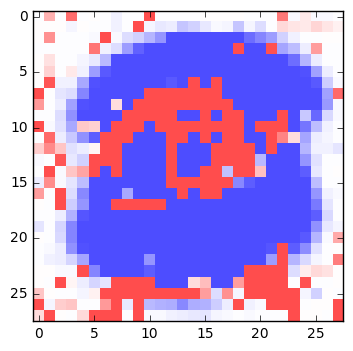

In [61]:
plot_noise()

흥미롭게도, 이 신경망은 이들 최적화 전에 깨끗한 이미지에 대한 것보다 노이즈 이미지에 대해 더 높은 분류 정확도를 보인다.

Accuracy on Test-Set: 97.5% (9750 / 10000)
Example errors:


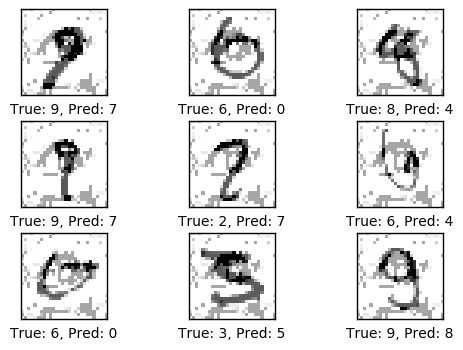

Confusion Matrix:
[[ 969    0    0    0    0    0    3    0    6    2]
 [   0 1123    3    1    1    0    1    0    5    1]
 [   5    1  998    4    5    0    1    5   13    0]
 [   0    0    1  992    0    8    0    4    4    1]
 [   1    0    2    0  964    0    5    1    2    7]
 [   2    0    0    4    0  877    2    1    5    1]
 [   9    3    1    0    7    6  926    0    6    0]
 [   1    3   13    3    2    1    0  987    0   18]
 [   5    0    1    7    2    3    1    5  945    5]
 [   5    5    0    7   14    2    0    5    2  969]]


In [62]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

### Performance on clean images

신경망이 깨끗한 이미지에 대해 어떻게 수행하는지 보자. 그러므로 우리는 적대적 노이즈를 0으로 초기화한다.

In [63]:
init_noise()

신경망은 이제 노이즈 낀 이미지와 비교하여 깨끗한 이미지에 더 낮은 성능을 보인다.

Accuracy on Test-Set: 93.4% (9341 / 10000)
Example errors:


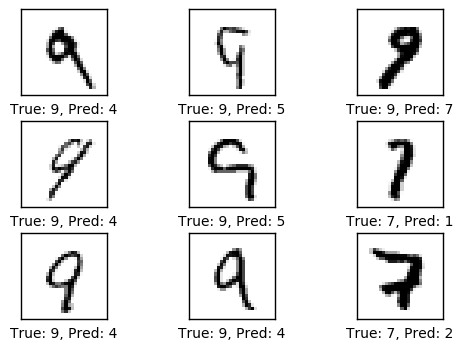

Confusion Matrix:
[[ 973    0    1    0    0    1    5    0    0    0]
 [   0 1127    4    1    0    0    3    0    0    0]
 [   5    2 1025    0    0    0    0    0    0    0]
 [   0    0   11  983    0   12    0    2    2    0]
 [   0    2    4    0  961    0   13    0    2    0]
 [   2    0    1    1    0  884    4    0    0    0]
 [   4    3    0    0    1    3  947    0    0    0]
 [   7   19   59    2   17    1    0  919    4    0]
 [  30    2   20   12    4   20   35    1  850    0]
 [  18   12    7   12  191   65    4   17   11  672]]


In [64]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## Close TensorFlow Session

텐서플로 사용을 마쳤고, 리소스를 풀기 위해 세션을 닫는다.

In [65]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# session.close()

## Discussion

우리는 위에 실험에서 단일 타겟 클래스에 대한 적대적 이미지에 면역인 신경망을 만드는 것이 가능함을 보았다. 이것은 타겟 클래스에 잘못 분류되게 하는 적대적 노이즈를 찾는 것이 불가능해졌다. 하지만 신경망이 모든 타겟 클래스에 면역인 것은 분명히 불가능했다. 아마도 이것은 다른 방법을 사용하여 가능할 것이다.

한가지 제안은 각 타겟 클래스에 대해 차례로 전체 최적화를 수행하는 것 대신에 다른 타겟 클래스에 대한 면역 학습을 내재 시키는 것이다. 이것은 위의 소스코드를 약간 변경함으로써 가능하다.

또다른 제안은 총 11개의 신경망을 갖는 신경망의 2 단계를 갖는 것일 수 있다. 첫번째 단계에서 신경망은 입력 이미지를 분류하기 위해 사용된다. 이 신경망은 적대적 노이즈에 면역되지 않았다. 두번째 단계의 또다른 신경망은 첫번째 단계에서 예측된 클래스에 따라 선택된다. 두번째 단계의 신경망은 각 타켓 클래스에 대한 적대적 노이즈에 면역되어 있다. 그래서 적대적노이즈가 적대적 노이즈를 갖는 첫번째 단계의 신경망을 바보로 만들지만 두번재 단계의 신겸앙이 이 특정 타겟 클래스에 대한 노이즈에 면역이다.

이것은 클래스의 숫자가 작을 때 동작하지만 큰 숫자에는 실행할 수 없을 것이다. e.g. 이미지넷 데이터셋은 1000개 클래스이고, 두번째 티어에서 1000개의 신경망을 학습할 필요가 있다. 이것은 실용적이지 않다.

## Conclusion

이 튜토리얼은 MNIST 데이터셋에 대한 적대적 노이즈를 찾는 법을 보였다. 거의 모든 입력 이미지를 타겟 클래스로 잘못 분류하게 만드는 하나의 노이즈 패턴은 각 클래스에 대해 찾아진다.

MNIST에 대한 노이즈 패턴은 사람 눈으로 명확히 보인다. 하지만 고 해상도 이미지에서 작동하는 더 큰 신경망에 대해서는 더 미세한 노이즈 패턴이 발견될 수 있다. e.g. 이미지넷 데이터셋

이 튜토리얼은 또한 적대적 노이즈에 면역인 신경망을 만드는 방법을 실험했다. 이것은 하나의 타겟 클래스에는 잘 작동되지만 이 실험된 방법은 신경망이 모든 타겟 클래스에 대해 면역으로 만들기는 불가능했다

## Exercises

* 적대적 노이즈에 대한 최적화 반복을 덜하거나 더 해보라
* 왜 이 튜토리얼은 적대적 노이즈를 찾기 위해 30 반복보다 작은 값이 필요했던 튜토리얼 11보다 더 많은 최적화 반복이 필요한가?
* `noise_limit`와 `noise_l2_weight` 에 대한 다른 설정을 시도하라. 적대적 노이즈와 분류 정확도에 영향을 어떻게 미치는가?
* 타겟 클래스 1에 대한 적대적 노이즈를 찾아라. 이것이 타겟 클래스 3에 대해 잘 작동하는가?
* 적대적 노이즈에 면역인 신경망을 만들기 위한 더 나은 방법을 찾을 수 있을까?
* 튜토리얼 11에서처럼 개별 이미지에 대해 생성된 적대적 노이즈에 면역되는가?
* 다른 설정으로 다른 신경망을 만들기를 시도하라. 하나의 신경망에 대한 적대적 노이즈가 다른 신경망에도 동작하는가?
* MNIST 대신 CIFAR-10 데이터셋을 사용해서 시도하라. 튜토리얼 6에서 코드를 재사용할 수 있다.
* 이미지넷 데이터셋과 인셉션 모델에 대한 적대적 노이즈를 어떻게 찾을 수 있을까?
* 친구에게 이 프로그램이 어떻게 작동하는지 설명하라

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.